# Packages

In [600]:
# Visualisation
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from pyvis.network import Network

# Data analysis / Data processing
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', None)
pd.options.display.float_format = "{:,.4f}".format
from datetime import time, timedelta, datetime
import numpy as np
import networkx as nx
from collections import defaultdict
import ast

# Maths & Stats
import math 
import scipy.stats as st
from scipy import stats
from scipy.stats import norm
import statsmodels.stats.weightstats as ws
from statsmodels.stats.proportion import test_proportions_2indep
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
# from ambrosia.designer import Designer
# from ambrosia.tester import Tester
import expab
from sklearn.linear_model import Ridge
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error


# System library
import os
import ipywidgets
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
tqdm.pandas()
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%config InlineBackend.figure_format='retina'
# from itables import init_notebook_mode
# init_notebook_mode(all_interactive=True)
import openpyxl

# Data connection
from google.cloud import bigquery
bigquery_client = bigquery.Client(project='analytics-dev-333113')


# Useful functions
def read_bq(query, project='analytics-dev-333113'):
    client = bigquery.Client(project=project)
    query_job = client.query(query)
    result_df = query_job.to_dataframe()
    return result_df

def display_side_by_side(*args):

    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(
        html_str.replace('table','table style="display:inline"'), 
        raw=True
    )

def cycle_sql(start, end, query, weeks=False):
    """
    You have to use {date} in your script to add cycle date into this backets
    """
    date_start = datetime.strptime(start, '%Y-%m-%d')
    date_end = datetime.strptime(end, '%Y-%m-%d')

    if weeks == False:
        daterange = [(date_start + timedelta(days=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days)+1)]
    else:
        daterange = [(date_start + timedelta(weeks=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days//7)+1)] # weeks dividing days by 7

    total_df = pd.DataFrame()

    counter = 0

    for date in daterange:
        counter+=1
        print(f"{counter}) Uploading - {date}:", datetime.today().strftime('%Y-%m-%d %H:%M:%S'))
        script = query.format(date = date)
        df_cycle = bigquery_client.query(script).to_dataframe()
        if df_cycle.empty == True:
            print('Dataframe is empty')
        total_df = pd.concat([df_cycle, total_df])
    return total_df  

def writing_excel(name:str, dataset1=None, dataset2=None, dataset3=None, dataset4=None):
    with pd.ExcelWriter(f"{name}.xlsx") as writer:

    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet

        if dataset1 is not None:
            if dataset2 is not None:
                if dataset3 is not None:
                    if dataset4 is not None:
                        dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                        #   index=False
                                            )
                        dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                        #   index=False
                                            )
                        dataset3.to_excel(writer, sheet_name=f"3-{name}", 
                                        #   index=False
                                            )
                        dataset4.to_excel(writer, sheet_name=f"4-{name}", 
                                        #   index=False
                                            )
                    else:
                        dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                        #   index=False
                                            )
                        dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                        #   index=False
                                            )
                        dataset3.to_excel(writer, sheet_name=f"3-{name}", 
                                        #   index=False
                                            )
                else:
                    dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                    #   index=False
                                        )
                    dataset2.to_excel(writer, sheet_name=f"2-{name}", 
                                    #   index=False
                                        )
            else:
                dataset1.to_excel(writer, sheet_name=f"1-{name}", 
                                #   index=False
                                    )

        print('DataFrame is written to Excel File successfully.') 

## Functions

# Design

### Поинты:
- Нужно тестовые города разделить на 3-4 группы и к каждой из них подобрать синтетические города в контексте двух метрик (Прокси и инциденты)
- Нужно измерить MDE для каждой из метрики
- Оформить документ и ответить на вопросы: сколько времени заложить на тест и какой эффект можем ожидать

### Choosing the cities and comparing

In [5]:
df_metric = read_bq("""
WITH metrics AS (SELECT t1.city_id,
                        t2.city_name,
                        t2.country_name,
                        IF(t1.city_id IN
                           (4226, 4143, 5495, 22796, 4516, 4261, 4231, 4263, 23089, 4200, 5483, 4404, 4228, 19943, 5568,
                            4257, 4196,
                            4267, 4242, 4225, 5513, 5573, 4272, 22654, 4155, 6083, 4266, 6117, 4397, 4227, 23233, 4271,
                            4599, 7236, 4269,
                            22737, 5368, 4396, 4230, 4385, 4199, 4255, 5536, 5548, 5589, 4264, 4229, 4726, 23130, 5291,
                            5600, 4198,
                            22817, 42833, 5535, 4234, 4197, 6587, 4243), 1, 0) AS group_name,
                        SUM(rides_count)                                          rides_count,
                        SUM(orders_count)                                         orders_count,
                        SUM(tenders_count)                                        tenders_count,
                        SUM(bid_count)                                            bid_count,
                        SUM(rides_count_from_feed)                                rides_count_from_feed,
                        SUM(rides_count_from_sn)                                  rides_count_from_sn,
                        SUM(gmv_clean_usd)                                        gmv,
                        SUM(orders_with_driver_arrived_late_count)                orders_with_driver_arrived_late_count,
                        SUM(orders_with_driver_arrived_early_count)               orders_with_driver_arrived_early_count,
                        SUM(pass_with_third_ride_count)                           pass_with_third_ride_count,
                        SUM(rides_count_from_autobid)                             rides_count_from_autobid,
                        AVG(ETA_sum)                                              avg_eta,
                        AVG(RTA_sum)                                              avg_rta,
                        SUM(reorders_count)                                       reorders_count,
                        SUM(canceled_arrived_orders_count)                        canceled_arrived_orders_count,
                        SUM(canceled_started_orders_count)                        canceled_started_orders_count,
                        SAFE_DIVIDE(SUM(gmv_clean_usd), SUM(rides_count))         avg_ride_price
                 FROM indriver-bi.incity.tbl_incity_growth_metrics_detail t1
                          JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                               ON t1.city_id = t2.city_id
                 WHERE 1 = 1
                   AND user_type = 'pass'
                   AND t2.macroregion_name IN ('Latin America', 'Brazil')
                   AND metric_date_utc >= '2025-01-01'
                 GROUP BY 1, 2, 3, 4),
     incidents AS (SELECT t1.city_id,
                          t1.city_name,
                          SUM(SAFE_DIVIDE(t1.incidents, t2.rides) * 100000) / COUNT(t1.city_id)      AS inc_rate,
                          SUM(SAFE_DIVIDE(t1.conf_incidents, t2.rides) * 100000) / COUNT(t1.city_id) AS conf_inc_rate
                   FROM (SELECT t1.city_id,
                                t1.city_name,
                                DATE_TRUNC(incident_date, MONTH)                              AS monthly,
                                COUNT(redmine_id)                                             AS incidents,
                                COUNT(IF(information_status = 'Confirmed', redmine_id, NULL)) AS conf_incidents
                         FROM indriver-bi.safety.vw_safety_incidents_detail t1
                         WHERE incident_date >= '2025-01-01'
                         GROUP BY 1, 2, 3) t1
                            LEFT JOIN (SELECT city_id,
                                              DATE_TRUNC(metric_date, MONTH) AS monthly,
                                              SUM(rides_count)               AS rides
                                       FROM indriver-bi.incity.tbl_incity_growth_metrics_detail
                                       WHERE user_type = 'pass'
                                         AND metric_date >= '2025-01-01'
                                       GROUP BY 1, 2) t2 ON t1.city_id = t2.city_id AND t1.monthly = t2.monthly
                   GROUP BY 1, 2),
     appeals AS (SELECT city_id,
                        ROUND(SUM(appeals) / COUNT(city_id), 0) AS mean_appeals
                 FROM (SELECT city_id,
                              DATE_TRUNC(DATE(created_at), MONTH) AS monthly,
                              COUNT(order_uuid)                   AS appeals
                       FROM dwh-storage-327422.ods_review.appeal
                       WHERE DATE(created_at) >= '2025-01-01'
                       GROUP BY 1, 2)
                 GROUP BY 1),
     reviews AS (SELECT city_id,
                        ROUND(SUM(reviews) / COUNT(city_id), 0) AS mean_reviews
                 FROM (SELECT city_id,
                              DATE_TRUNC(DATE(created_at), MONTH) AS monthly,
                              COUNT(order_uuid)                   AS reviews
                       FROM indriver-e6e40.ods_moderation_feed_red_pill.review
                       WHERE DATE(created_at) >= '2025-01-01'
                       GROUP BY 1, 2)
                 GROUP BY 1)
SELECT t1.*,
       COALESCE(appeals.mean_appeals, 0) AS mean_appeals,
       COALESCE(reviews.mean_reviews, 0) AS mean_reviews,
       COALESCE(t2.inc_rate, 0)          AS inc_rate,
       COALESCE(t2.conf_inc_rate, 0)     AS conf_inc_rate,
FROM metrics t1
         LEFT JOIN appeals ON t1.city_id = appeals.city_id
         LEFT JOIN reviews ON t1.city_id = reviews.city_id
         LEFT JOIN incidents t2
                   ON t1.city_id = t2.city_id
""")

df_metric.head()

,city_id,city_name,country_name,group_name,rides_count,orders_count,tenders_count,bid_count,rides_count_from_feed,rides_count_from_sn,gmv,orders_with_driver_arrived_late_count,orders_with_driver_arrived_early_count,pass_with_third_ride_count,rides_count_from_autobid,avg_eta,avg_rta,reorders_count,canceled_arrived_orders_count,canceled_started_orders_count,avg_ride_price,mean_appeals,mean_reviews,inc_rate,conf_inc_rate
0,5528,Santiago de los Caballeros,Dominican Republic,0,1013181,1690284,5277974,5879257,195687,817494,"3,234,714.42",460987,173573,12744,0,81.13,6.99,393234,67485,8520,3.19,"4,149.00","2,472.00",33.98,6.30
1,4540,Belo Horizonte,Brazil,0,795261,3014447,3864120,5756853,383810,411451,"3,229,205.53",235545,261217,18465,0,9.60,8.37,853616,64687,8662,4.06,"2,853.00","2,386.00",147.08,59.72
2,5600,Rancagua,Chile,1,141920,333721,470669,638818,64765,77155,"522,562.09",29005,48966,2405,0,7.86,6.90,73167,6770,751,3.68,252.00,275.00,60.68,19.03
3,5277,Nuevo Laredo,Mexico,0,34743,149174,91823,123203,16878,17865,"161,705.04",6631,12626,1180,0,8.55,7.62,38180,1121,149,4.65,40.00,64.00,19.21,4.37
4,21430,Tramandaí,Brazil,0,322,1685,1267,1756,132,190,"1,208.70",118,73,14,0,9.11,8.10,374,26,4,3.75,5.00,3.00,"1,204.82",0.00


#### K-means to gather the groups

In [54]:
df_metric.describe()

,city_id,group_name,rides_count,orders_count,tenders_count,bid_count,rides_count_from_feed,rides_count_from_sn,gmv,orders_with_driver_arrived_late_count,orders_with_driver_arrived_early_count,pass_with_third_ride_count,rides_count_from_autobid,avg_eta,avg_rta,reorders_count,canceled_arrived_orders_count,canceled_started_orders_count,avg_ride_price,mean_appeals,mean_reviews,inc_rate,conf_inc_rate
count,"4,950.00","4,950.00","4,950.00","4,950.00","4,950.00","4,528.00","4,950.00","4,950.00","4,950.00","4,950.00","4,950.00","4,950.00","4,950.00","4,289.00","4,180.00","4,950.00","4,950.00","4,950.00","4,121.00","4,950.00","4,950.00","4,950.00","4,950.00"
mean,"20,745.17",0.01,"78,768.21","146,604.09","288,618.67","386,599.63","34,972.36","43,795.41","270,259.65","16,840.16","21,793.34",772.92,0.43,7.27,6.72,"30,340.75","3,511.73",457.70,4.11,123.00,174.95,246.62,100.95
std,"10,032.82",0.10,"1,076,621.99","1,985,775.48","4,271,959.42","5,632,497.41","590,991.26","500,868.76","4,055,648.28","287,838.91","239,067.17","9,199.67",19.80,5.85,5.53,"381,499.66","52,729.87","6,850.55",2.41,"1,643.54","2,347.44","3,222.72","1,923.82"
min,"4,142.00",0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.05,0.00,0.00,0.00,0.07,0.00,0.00,0.00,0.00
25%,"8,127.25",0.00,1.00,17.00,8.00,13.00,0.00,1.00,5.18,0.00,0.00,0.00,0.00,5.06,4.63,2.00,0.00,0.00,2.91,0.00,0.00,0.00,0.00
50%,"22,562.50",0.00,11.00,76.00,46.00,66.00,0.00,7.00,41.76,3.00,3.00,0.00,0.00,6.50,6.00,12.00,1.00,0.00,3.70,0.00,0.00,0.00,0.00
75%,"24,622.75",0.00,78.00,395.75,278.00,359.00,6.00,56.00,297.56,19.00,22.00,3.00,0.00,8.38,7.92,75.00,5.00,1.00,4.70,1.00,1.00,0.00,0.00
max,"43,409.00",1.00,"60,272,737.00","110,579,880.00","248,093,902.00","317,362,804.00","35,905,982.00","24,366,755.00","240,044,220.70","17,811,148.00","8,835,022.00","486,032.00","1,328.00",250.44,184.46,"19,920,720.00","2,967,905.00","378,966.00",46.69,"87,361.00","124,125.00","100,000.00","100,000.00"


In [114]:
df_metric.loc[df_metric['city_id'].isin([22796, 23089, 42833, 4726, 6083, 23233, 6117, 22654, 22817, 5495, 19943]), 'group_name'] = 0

In [ ]:
df_treatment = df_metric[df_metric['group_name']==1].copy()
df_treatment = df_treatment.fillna(0)

In [ ]:

def cluster_and_normalize_data(df: pd.DataFrame) -> pd.DataFrame:

    excluded_columns = ['city_id', 'city_name', 'country_name', 'group_name']

    numerical_columns = [col for col in df.columns if col not in excluded_columns and pd.api.types.is_numeric_dtype(df[col])]

    if not numerical_columns:
        raise ValueError("Check the data type")

    df_processed = df.copy()

    X = df_processed[numerical_columns]


    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    
    df_processed['cluster_label'] = kmeans.fit_predict(X_scaled)


    df_processed['cluster_group'] = df_processed['cluster_label'] + 1

    df_processed = df_processed.drop(columns=['cluster_label'])

    return df_processed

df_treat_group = cluster_and_normalize_data(df_treatment)

In [594]:
df_treat_group.groupby(['cluster_group'], as_index=False)['city_name'].apply(list)

,cluster_group,city_name
0,1,"[Rancagua, Concepción, Tijuana, Toluca, Tegucigalpa y Comayagüela, Guadalajara, Buenos Aires, San Pedro Sula, Puebla, Kingston, Mexico city, Monterrey, Santiago]"
1,2,[Lima]
2,3,"[Temuco, Antofagasta, Arica, Coquimbo y LaSerena, San Jose, Ciudad Juarez, Santiago de Queretaro, Leon de los Aldama, Cali, Chiclayo, Osorno, Portoviejo, Copiapó, Manta, Puerto Montt, Iquique y Alto Hospicio, Villavicencio, Trujillo, Calama, San Luis Potosi, Barranquilla, Chihuahua, Guayaquil, Medellin, Cucuta, Guatemala City, Quito, Bogota, Panama]"


In [343]:
df_treat_group.groupby('cluster_group', as_index=False)[['rides_count', 'mean_appeals', 'mean_reviews', 'inc_rate', 'conf_inc_rate']].mean()

,cluster_group,rides_count,mean_appeals,mean_reviews,inc_rate,conf_inc_rate
0,1,"1,515,349.46","3,015.77","4,953.77",54.64,16.14
1,2,"60,272,737.00","87,361.00","124,125.00",31.50,4.93
2,3,"4,782,540.28","7,249.00","10,682.93",30.90,6.27


##### Checking the correctness of choosing

In [506]:
groups  = [1,2,3]
cities_groups = [(5600, 4261, 4228, 5291, 5536, 4225, 5483, 5535, 4226, 5368, 4143, 4155, 4200),(4199),(4264, 4263, 4267, 4266, 5513, 4227, 4234, 4229, 4255, 4272, 5589, 4397, 5573, 4396, 4269, 4271, 4516, 4257, 5568, 4231, 4243, 4230, 4385, 4242, 4196, 4198, 4404, 4197, 5548)]

df_proxy = read_bq(f"""
            WITH users AS (SELECT DISTINCT user_id,
                               metric_date_utc,
                               t1.city_id,
                               t2.city_name,
                               t1.country_id,
                               t2.country_name
               FROM indriver-bi.incity.tbl_incity_growth_metrics_detail t1
                        JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                             ON t1.city_id = t2.city_id
               WHERE user_type = 'pass'
                 AND orders_count > 0
                 AND metric_date_utc >= '2025-03-01'
                 AND t2.macroregion_name IN ('Latin America', 'Brazil')
               QUALIFY ROW_NUMBER() OVER (PARTITION BY user_id, metric_date_utc ORDER BY city_id) = 1),
     appeals AS (SELECT target_id              user_id,
                        DATE(t1.created_at) AS date,
                        COUNT(DISTINCT uuid)   cnt_appeals
                 FROM indriver-e6e40.ods_moderation_feed_red_pill.appeal t1
                          JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                               ON t1.city_id = t2.city_id
                          LEFT JOIN
                      indriver-e6e40.ods_ds_moderation_system_cdc.violation_review_v3 t3
                      ON t1.uuid = JSON_EXTRACT_SCALAR(t3.payload, '$.uuid')
                 WHERE DATE(t1.created_at) BETWEEN '2025-03-01' AND '2025-06-01'
                   AND DATE(t3.export_raw_dt) BETWEEN '2025-03-01' AND '2025-06-01'
                   --AND t1.initiator_id = 1 --жалоба от пассажира водиле
                   AND t1.initiator_id = 0 --жалоба от водилы пассажиру
                   AND t2.macroregion_name IN ('Latin America', 'Brazil')
                   AND JSON_EXTRACT_SCALAR(t3.model, '$.result.top_category[0]') NOT IN ('CATEGORY_TEXT_NOT_RECOGNISED',
                                                                                         'CATEGORY_LOCATION_DISPUTE',
                                                                                         'CATEGORY_RIDE_REFUSAL',
                                                                                         'CATEGORY_CANCELLED_BY_DRIVER_REQUEST',
                                                                                         'CATEGORY_BARGAINING_AFTER_ACCEPT',
                                                                                         'CATEGORY_PASSENGER_WAS_LATE',
                                                                                         'CATEGORY_DRIVER_WAS_LATE',
                                                                                         'CATEGORY_APP_PROBLEM',
                                                                                         'CATEGORY_POSITIVE_REVIEW',
                                                                                         'CATEGORY_DIFFERENT_CAR',
                                                                                         'CATEGORY_DRIVER_REPORTED_CAR_MALFUNCTION',
                                                                                         'CATEGORY_STRANGER_IN_CAR')
                 GROUP BY 1, 2),
     reviews AS (SELECT target_id          AS  user_id,
                        DATE(r.created_at) AS  date,
                        COUNT(DISTINCT r.uuid) cnt_reviews
                 FROM indriver-e6e40.ods_moderation_feed_red_pill.review r
                          JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                               ON r.city_id = t2.city_id
                          LEFT JOIN
                      indriver-e6e40.ods_ds_moderation_system_cdc.violation_review_v3 src
                      ON JSON_EXTRACT_SCALAR(src.payload, '$.uuid') = r.uuid
                 WHERE DATE(r.created_at) BETWEEN '2025-03-01' AND '2025-06-01'
                   AND DATE(src.export_raw_dt) BETWEEN '2025-03-01' AND '2025-06-01'
                   AND rating < 5
                   AND r.visibility_id = 1 --жалобы от водителя на пассажира
                   AND t2.macroregion_name IN ('Latin America', 'Brazil')
                   AND
                     JSON_EXTRACT_SCALAR(src.model, '$.result.top_category[0]') NOT IN ('CATEGORY_TEXT_NOT_RECOGNISED',
                                                                                        'CATEGORY_DIRTY_CABIN',
                                                                                        'CATEGORY_SUSPICIOUS_AREA', --УДАЛИТЬ?
                                                                                        'CATEGORY_ASSAULT', --УДАЛИТЬ?
                                                                                        'CATEGORY_BARGAINING_AFTER_ACCEPT',
                                                                                        'CATEGORY_POSITIVE_REVIEW',
                                                                                        'CATEGORY_DIFFERENT_CAR',
                                                                                        'CATEGORY_PASSENGER_REPORTED_CAR_MALFUNCTION',
                                                                                        'CATEGORY_NO_CHANGE',
                                                                                        'CATEGORY_DANGEROUS_DRIVING')
                 GROUP BY 1, 2),
     orders_raw AS (SELECT DISTINCT order_uuid,
                                    created_date_order_part AS date,
                                    user_id
                    FROM indriver-e6e40.emart.incity_detail t1
                             JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                                  ON t1.city_id = t2.city_id
                    WHERE created_date_order_part BETWEEN '2025-03-01' AND '2025-06-01'
                      AND t2.macroregion_name IN ('Latin America', 'Brazil')),
     support_raw AS (SELECT DISTINCT t1.id                       support_id,
                                     DATE(t1.created_dt_part) AS date,
                                     LOWER(t4.order_id)          order_uuid
                     FROM indriver-e6e40.ods_customer_support.request t1
                              JOIN
                          indriver-bi.customer_service.tbl_customer_support_chats_just_detail t2
                          ON t1.id = t2.request_id
                              JOIN
                          dwh-storage-327422.ods_customer_support.chat_request_entry t4 ON t1.id = t4.request_id
                              JOIN indriver-e6e40.heap.vw_macroregion_mapping geo
                                   ON t4.city_id = geo.city_id
                              JOIN
                          (SELECT DISTINCT country_id, country_name, city_id FROM indriver-bi.heap.vw_geo_mapping) t3
                          ON t2.country_name = t3.country_name
                     WHERE DATE(t1.created_dt_part) BETWEEN '2025-03-01' AND '2025-06-01'
                       AND t4.created_dt_part BETWEEN '2025-03-01' AND '2025-06-01'
                       AND contact_category IS NOT NULL
                       AND contact_reason IS NOT NULL
                       AND who_contacts = 'Driver'
                       AND contact_category IN ('Complaints against Passenger', 'Safety')
                       AND geo.macroregion_name IN ('Latin America', 'Brazil')),
     support AS (SELECT orders_raw.user_id,
                        orders_raw.date,
                        COUNT(DISTINCT support_id) cnt_support
                 FROM orders_raw
                          JOIN
                      support_raw ON orders_raw.order_uuid = support_raw.order_uuid
                 GROUP BY 1, 2)
SELECT t1.metric_date_utc,
       t1.city_id,
       t1.city_name,
       t1.country_name,
       COUNT(DISTINCT t1.user_id)            AS users,
       COALESCE(SUM(appeals.cnt_appeals), 0) AS appeals,
       COALESCE(SUM(reviews.cnt_reviews), 0) AS reviews,
       COALESCE(SUM(support.cnt_support), 0) AS support
FROM users t1
         LEFT JOIN
     appeals ON t1.user_id = appeals.user_id AND t1.metric_date_utc = appeals.date
         LEFT JOIN
     reviews ON t1.user_id = reviews.user_id AND t1.metric_date_utc = reviews.date
         LEFT JOIN
     support ON t1.user_id = support.user_id AND t1.metric_date_utc = support.date
GROUP BY 1, 2, 3, 4
    """)
    
df_ir = read_bq(f"""
SELECT t1.city_id,
       t1.city_name,
       t1.weekly,
       SUM(SAFE_DIVIDE(t1.incidents, t2.rides) * 100000) / COUNT(t1.city_id)      AS inc_rate,
       SUM(SAFE_DIVIDE(t1.conf_incidents, t2.rides) * 100000) / COUNT(t1.city_id) AS conf_inc_rate
FROM (SELECT DATE_TRUNC(incident_date, month)                               AS weekly,
             t1.city_id,
             t1.city_name,
             COUNT(redmine_id)                                             AS incidents,
             COUNT(IF(information_status = 'Confirmed', redmine_id, NULL)) AS conf_incidents
      FROM indriver-bi.safety.vw_safety_incidents_detail t1
               JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                    ON
                        t1.city_id = t2.city_id
      WHERE incident_date >= '2024-11-01'
        AND t2.macroregion_name IN ('Latin America', 'Brazil')
      GROUP BY 1, 2, 3) t1
         LEFT JOIN (SELECT city_id,
                           DATE_TRUNC(metric_date, month) AS weekly,
                           SUM(rides_count)              AS rides
                    FROM indriver-bi.incity.tbl_incity_growth_metrics_detail
                    WHERE user_type = 'pass'
                      AND metric_date >= '2024-11-01'
                    GROUP BY 1, 2) t2 ON t1.city_id = t2.city_id AND t1.weekly = t2.weekly
GROUP BY 1, 2, 3
    """)
    

df_proxy['appeals_c'] = df_proxy['users'] / df_proxy['appeals']
df_proxy['reviews_c'] = df_proxy['users'] / df_proxy['reviews'] 
df_proxy['support_c'] = df_proxy['users'] / df_proxy['support'] 
df_proxy['composite'] = df_proxy['appeals_c'] + df_proxy['reviews_c'] + df_proxy['support_c']



def plot_metrics_by_date(
    df,
    metrics,
    date_col='metric_date_utc',
    group_by_col=None,
    group_by_val=None,
    title='Metrics Over Time'
):
    """
    Рисует временные ряды по выбранным метрикам.
    
    :param df: DataFrame с данными
    :param metrics: список метрик (столбцов), которые надо отрисовать
    :param date_col: имя колонки с датой
    :param group_by_col: (опц.) столбец для фильтрации (например, 'country_name', 'group', 'city_id')
    :param group_by_val: (опц.) значение для фильтрации
    :param title: заголовок графика
    """

    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    if group_by_col and group_by_val is not None:
        df = df[df[group_by_col] == group_by_val]

    df_grouped = df.groupby(date_col)[metrics].sum().reset_index()

    plt.figure(figsize=(12, 6))

    for metric in metrics:
        plt.plot(df_grouped[date_col], df_grouped[metric], label=metric, linewidth=2)

    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title="Metrics", fontsize=10)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def grouping(row):
    if row['city_id'] in cities_groups[0]:
        return 1
    elif row['city_id'] in [cities_groups[1]]:
        return 2
    elif row['city_id'] in cities_groups[2]:
        return 3
    else:
        return 0


df_proxy['segment'] = df_proxy.apply(grouping, axis=1)
df_ir['segment'] = df_ir.apply(grouping, axis=1)

In [507]:
df_proxy

df_proxy = df_proxy.replace([np.inf, -np.inf], np.nan)

columns = ['users', 'appeals', 'reviews', 'support', 'appeals_c', 'reviews_c', 'support_c', 'composite', 'segment']

for column in columns:
    df_proxy[column] = df_proxy[column].fillna(0)

df_proxy['metric_date_utc'] = pd.to_datetime(df_proxy['metric_date_utc'])
df_proxy = df_proxy[df_proxy['metric_date_utc']<='2025-06-02']
df_proxy.head()

,metric_date_utc,city_id,city_name,country_name,users,appeals,reviews,support,appeals_c,reviews_c,support_c,composite,segment
0,2025-03-01,4408,Riobamba,Ecuador,9195,46,20,1,199.89,459.75,"9,195.00","9,854.64",0
1,2025-03-01,5589,Osorno,Chile,8488,27,25,0,314.37,339.52,0.00,0.00,3
2,2025-03-01,4194,Merida,Mexico,44081,91,66,15,484.41,667.89,"2,938.73","4,091.03",0
3,2025-03-01,4267,Arica,Chile,12700,57,53,3,222.81,239.62,"4,233.33","4,695.76",3
4,2025-03-01,4388,Ibarra,Ecuador,5714,34,17,2,168.06,336.12,"2,857.00","3,361.18",0


In [508]:
df_proxy_treat = df_proxy[df_proxy['segment']>0].groupby(['segment', 'metric_date_utc'], as_index=False)[['users', 'appeals', 'reviews', 'support', 'appeals_c', 'reviews_c', 'support_c', 'composite']].mean()

df_proxy_treat['city_id'] = df_proxy_treat['segment']
df_proxy_treat['city_name'] = 'city_' + df_proxy_treat['segment'].astype('str')
df_proxy_treat['country_name'] = 'country_' + df_proxy_treat['segment'].astype('str')

df_proxy_control = df_proxy[df_proxy['segment']==0]

df_proxy_treat.head()


,segment,metric_date_utc,users,appeals,reviews,support,appeals_c,reviews_c,support_c,composite,city_id,city_name,country_name
0,1,2025-03-01,"14,790.38",81.54,49.31,14.77,205.64,338.17,888.02,"1,324.11",1,city_1,country_1
1,1,2025-03-02,"14,318.54",85.38,44.85,14.08,189.28,393.20,"1,149.34","1,652.72",1,city_1,country_1
2,1,2025-03-03,"13,170.92",62.31,37.92,12.62,265.00,497.47,"1,235.78","1,760.85",1,city_1,country_1
3,1,2025-03-04,"11,024.54",56.46,35.46,10.92,226.13,375.66,"1,336.41","1,938.19",1,city_1,country_1
4,1,2025-03-05,"11,105.31",54.31,32.69,9.31,231.95,468.34,"1,462.57","2,016.09",1,city_1,country_1


In [509]:
df_proxy_treat.groupby('city_name', as_index=False)['composite'].mean()

,city_name,composite
0,city_1,"1,837.32"
1,city_2,"3,911.74"
2,city_3,"4,480.68"


In [510]:
total_proxy = pd.concat([df_proxy_control, df_proxy_treat])

total_proxy.tail()

,metric_date_utc,city_id,city_name,country_name,users,appeals,reviews,support,appeals_c,reviews_c,support_c,composite,segment
277,2025-05-29,3,city_3,country_3,"29,703.17",123.07,73.21,9.21,276.66,408.02,"5,142.13","5,800.66",3
278,2025-05-30,3,city_3,country_3,"35,571.03",136.45,78.14,13.10,281.98,490.07,"3,642.08","4,388.66",3
279,2025-05-31,3,city_3,country_3,"40,854.48",160.10,93.90,10.79,280.61,445.53,"5,500.31","6,198.00",3
280,2025-06-01,3,city_3,country_3,"38,883.03",189.72,93.52,7.14,221.07,423.36,"7,131.50","7,703.79",3
281,2025-06-02,3,city_3,country_3,"34,110.41",0.00,0.00,0.00,0.00,0.00,0.00,0.00,3


In [511]:
df_ir_treat = df_ir[df_ir['segment']>0].groupby(['segment', 'weekly'], as_index=False)[['inc_rate', 'conf_inc_rate']].mean()

df_ir_treat['city_name'] = 'city_' + df_ir_treat['segment'].astype('str')
df_ir_treat['city_id'] = df_ir_treat['segment']

df_ir_control = df_ir[df_ir['segment']==0]

df_ir_treat.head()

,segment,weekly,inc_rate,conf_inc_rate,city_name,city_id
0,1,2024-11-01,32.06,14.07,city_1,1
1,1,2024-12-01,45.88,13.37,city_1,1
2,1,2025-01-01,55.70,18.24,city_1,1
3,1,2025-02-01,53.14,15.37,city_1,1
4,1,2025-03-01,57.78,15.61,city_1,1


### Choosing the cities (Pairs)

#### Incident rate

In [512]:
# Correlated cities

def corr_df(df, city_test, metric_name, control_cities):

    results = pd.DataFrame()
    df_analysis = df.pivot_table(columns='city_name', index='weekly', values='conf_inc_rate', aggfunc='mean').fillna(0)

    for city in control_cities:
    
        results_city = pd.DataFrame()

        # coeff = np.corrcoef(df_analysis[city_test], df_analysis[city])[1,0]
        coeff = df_analysis[city_test].corr(df_analysis[city], method='spearman')

        city_merged = city_test + '_' + city

        results_city['link'] = [city_merged]
        results_city['control'] = [city]
        results_city['coeff'] = [coeff]

        results = pd.concat([results, results_city])


    results = results.sort_values('coeff', ascending=False).head(10)


    return results
    
      

In [513]:
total_ir = pd.concat([df_ir_control, df_ir_treat])

total_ir['inc_rate'] = total_ir['inc_rate'].fillna(0)
total_ir['conf_inc_rate'] = total_ir['conf_inc_rate'].fillna(0)

total_ir.tail()

,city_id,city_name,weekly,inc_rate,conf_inc_rate,segment
19,3,city_3,2025-02-01,28.25,6.09,3
20,3,city_3,2025-03-01,31.40,6.12,3
21,3,city_3,2025-04-01,28.78,6.07,3
22,3,city_3,2025-05-01,27.67,6.15,3
23,3,city_3,2025-06-01,33.63,5.56,3


У меня есть 3 набора городов, к которым я подбираю города. Нужно выбрать самые скоррелированные города (Например, топ 10-15), а потом через регрессию прогнать и по коэффициентам выявить самые актуальные

In [514]:
test_city = ['city_3', 'city_2', 'city_1']

df_corr_cities = pd.DataFrame()

for test_city in test_city:

    df_res = corr_df(total_ir, test_city, 'conf_inc_rate', total_ir[total_ir['segment']==0]['city_name'].unique())
    df_res['segment'] = test_city

    df_corr_cities = pd.concat([df_corr_cities, df_res])


df_corr_cities.groupby('segment', as_index=False)['control'].apply(list)

,segment,control
0,city_1,"[Santiago de los Caballeros, Cuenca, Anápolis, Joinville, Franca, Curitiba, Armenia, Saltillo, Valparaíso - Viña del Mar, Uberaba]"
1,city_2,"[Villahermosa, Los Algarrobos, Santa Cruz do Sul, Piura, Talca, Pindamonhangaba, Sogamoso, Orizaba, Fazenda Rio Grande, Eunápolis]"
2,city_3,"[Punta Cana, Santa Ana, Jequié, Pelotas, Managua, Marinilla, Sonsonate, Luruaco, Cuiabá, San Miguel]"


In [ ]:
df_corr_cities

,link,control,coeff,segment
0,city_3_Punta Cana,Punta Cana,0.95,city_3
0,city_3_Santa Ana,Santa Ana,0.90,city_3
0,city_3_Jequié,Jequié,0.89,city_3
0,city_3_Pelotas,Pelotas,0.81,city_3
0,city_3_Managua,Managua,0.79,city_3
0,city_3_Marinilla,Marinilla,0.76,city_3
0,city_3_Sonsonate,Sonsonate,0.76,city_3
0,city_3_Luruaco,Luruaco,0.76,city_3
0,city_3_Cuiabá,Cuiabá,0.76,city_3
0,city_3_San Miguel,San Miguel,0.74,city_3


- city_1	[Santiago de los Caballeros, Cuenca, Anápolis, Joinville, Franca, Curitiba, Armenia, Saltillo, Valparaíso - Viña del Mar, Uberaba]
- city_2	[Villahermosa, Los Algarrobos, Santa Cruz do Sul, Piura, Talca, Pindamonhangaba, Sogamoso, Orizaba, Fazenda Rio Grande, Eunápolis]
- city_3	[Punta Cana, Santa Ana, Jequié, Pelotas, Managua, Marinilla, Sonsonate, Luruaco, Cuiabá, San Miguel]

#### Proxy metrics

In [438]:
def corr_df(df, city_test, metric_name, control_cities):

    results = pd.DataFrame()
    df_analysis = df.pivot_table(columns='city_name', index='metric_date_utc', values=metric_name, aggfunc='mean').fillna(0)

    for city in control_cities:
    
        results_city = pd.DataFrame()

        # coeff = np.corrcoef(df_analysis[city_test], df_analysis[city])[1,0]
        coeff = df_analysis[city_test].corr(df_analysis[city], method='spearman')

        city_merged = city_test + '_' + city

        results_city['link'] = [city_merged]
        results_city['control'] = [city]
        results_city['coeff'] = [coeff]

        results = pd.concat([results, results_city])


    results = results.sort_values('coeff', ascending=False).head(10)


    return results

total_proxy['users'] = total_proxy['users'].fillna(0)
total_proxy['appeals'] = total_proxy['appeals'].fillna(0)
total_proxy['reviews'] = total_proxy['reviews'].fillna(0)
total_proxy['support'] = total_proxy['support'].fillna(0)
total_proxy['appeals_c'] = total_proxy['appeals_c'].fillna(0)
total_proxy['reviews_c'] = total_proxy['reviews_c'].fillna(0)
total_proxy['support_c'] = total_proxy['support_c'].fillna(0)
total_proxy['composite'] = total_proxy['composite'].fillna(0)

total_proxy.head()

,metric_date_utc,city_id,city_name,country_name,users,appeals,reviews,support,appeals_c,reviews_c,support_c,composite,segment
1,2025-03-01,4193,Saltillo,Mexico,"59,133.00",145.00,126.00,12.00,407.81,469.31,"4,927.75","5,804.87",0
3,2025-03-01,4142,São Paulo,Brazil,"61,524.00",464.00,194.00,115.00,132.59,317.13,534.99,984.72,0
4,2025-03-01,4238,Torreon,Mexico,"2,107.00",9.00,7.00,3.00,234.11,301.00,702.33,"1,237.44",0
5,2025-03-01,4524,Manaus,Brazil,"39,178.00",220.00,53.00,39.00,178.08,739.21,"1,004.56","1,921.85",0
6,2025-03-01,4233,Aguascalientes,Mexico,"16,739.00",50.00,32.00,8.00,334.78,523.09,"2,092.38","2,950.25",0


In [439]:
test_city = ['city_3', 'city_2', 'city_1']

df_corr_cities = pd.DataFrame()

for test_city in test_city:

    df_res = corr_df(total_proxy, test_city, 'composite', total_proxy[total_proxy['segment']==0]['city_name'].unique())
    df_res['segment'] = test_city

    df_corr_cities = pd.concat([df_corr_cities, df_res])

df_corr_cities

,link,control,coeff,segment
0,city_3_Manaus,Manaus,0.30,city_3
0,city_3_Mazatlan,Mazatlan,0.29,city_3
0,city_3_Fazenda Rio Grande,Fazenda Rio Grande,0.28,city_3
0,city_3_Aguascalientes,Aguascalientes,0.27,city_3
0,city_3_Hermosillo,Hermosillo,0.26,city_3
0,city_3_Mexicali,Mexicali,0.26,city_3
0,city_3_Managua,Managua,0.26,city_3
0,city_3_Merida,Merida,0.25,city_3
0,city_3_Cancun,Cancun,0.24,city_3
0,city_3_Campeche,Campeche,0.22,city_3


In [440]:
df_corr_cities.groupby('segment', as_index=False)['control'].apply(list)

,segment,control
0,city_1,"[Belém, Merida, Cochabamba, Managua, Aguascalientes, Goiânia, Serra, Jaraguá do Sul, Puerto Vallarta, Cancun]"
1,city_2,"[San Salvador, Cancun, Hermosillo, Aguascalientes, Merida, Arequipa, Santo Domingo, Mazatlan, Culiacan, Mexicali]"
2,city_3,"[Manaus, Mazatlan, Fazenda Rio Grande, Aguascalientes, Hermosillo, Mexicali, Managua, Merida, Cancun, Campeche]"


## Set of cities
Proxy 
- city_1	[Belém, Merida, Cochabamba, Managua, Aguascalientes, Goiânia, Serra, Jaraguá do Sul, Puerto Vallarta, Cancun]
- city_2	[San Salvador, Cancun, Hermosillo, Aguascalientes, Merida, Arequipa, Santo Domingo, Mazatlan, Culiacan, Mexicali]
- city_3	[Manaus, Mazatlan, Fazenda Rio Grande, Aguascalientes, Hermosillo, Mexicali, Managua, Merida, Cancun, Campeche]

incident rate

- city_1	[Santiago de los Caballeros, Cuenca, Anápolis, Joinville, Franca, Curitiba, Armenia, Saltillo, Valparaíso - Viña del Mar, Uberaba]
- city_2	[Villahermosa, Los Algarrobos, Santa Cruz do Sul, Piura, Talca, Pindamonhangaba, Sogamoso, Orizaba, Fazenda Rio Grande, Eunápolis]
- city_3	[Punta Cana, Santa Ana, Jequié, Pelotas, Managua, Marinilla, Sonsonate, Luruaco, Cuiabá, San Miguel]


### Getting the coefficients with paired cities

In [363]:
total_proxy.head()

,metric_date_utc,city_id,city_name,country_name,users,appeals,reviews,support,appeals_c,reviews_c,support_c,composite,segment
2,2025-03-01,4381,Monclova,Mexico,"14,046.00",31.00,40.00,0.00,453.10,351.15,0.00,0.00,0
3,2025-03-01,5026,Corumbá,Brazil,"3,787.00",20.00,3.00,2.00,189.35,"1,262.33","1,893.50","3,345.18",0
4,2025-03-01,4408,Riobamba,Ecuador,"9,195.00",46.00,20.00,1.00,199.89,459.75,"9,195.00","9,854.64",0
5,2025-03-01,4247,Valledupar,Colombia,"9,059.00",39.00,21.00,1.00,232.28,431.38,"9,059.00","9,722.66",0
7,2025-03-01,4573,La Paz,Mexico,"7,383.00",21.00,14.00,3.00,351.57,527.36,"2,461.00","3,339.93",0


In [686]:
# data prep
total_proxy['metric_date_utc'] = pd.to_datetime(total_proxy['metric_date_utc'])
total_proxy = total_proxy[total_proxy['metric_date_utc']<= '2025-06-1']

cr_train = total_proxy[total_proxy['metric_date_utc']<'2025-05-10']
cr_test = total_proxy[total_proxy['metric_date_utc']>='2025-05-10']

# Incident rate
# test_city_1 = 'city_1'
# control_cities_1 = ['Santiago de los Caballeros', 'Cuenca', 'Anápolis', 'Joinville', 'Franca', 'Curitiba', 'Armenia', 'Saltillo', 'Valparaíso - Viña del Mar', 'Uberaba']

# test_city_2 = 'city_2'
# control_cities_2 = ['Villahermosa', 'Los Algarrobos', 'Santa Cruz do Sul', 'Piura', 'Talca', 'Pindamonhangaba', 'Sogamoso', 'Orizaba', 'Fazenda Rio Grande', 'Eunápolis']

# test_city_3 = 'city_3'
# control_cities_3 = ['Punta Cana', 'Santa Ana', 'Jequié', 'Pelotas', 'Managua', 'Marinilla', 'Sonsonate', 'Luruaco', 'Cuiabá', 'San Miguel']

# Proxy
test_city_1 = 'city_1'
control_cities_1 = ['Belém', 'Merida', 'Cochabamba', 'Managua', 'Aguascalientes', 'Goiânia', 'Serra', 'Jaraguá do Sul', 'Puerto Vallarta', 'Cancun']

test_city_2 = 'city_2'
control_cities_2 = ['San Salvador', 'Cancun', 'Hermosillo', 'Aguascalientes', 'Merida', 'Arequipa', 'Santo Domingo', 'Mazatlan', 'Culiacan', 'Mexicali']

test_city_3 = 'city_3'
control_cities_3 = ['Manaus', 'Mazatlan', 'Fazenda Rio Grande', 'Aguascalientes', 'Hermosillo', 'Mexicali', 'Managua', 'Merida', 'Cancun', 'Campeche']


pivot_df = cr_train.pivot_table(index='metric_date_utc', columns='city_name', values='composite')
# pivot_df = pivot_df.dropna()

X = pivot_df[control_cities_2].fillna(0)
y = pivot_df[test_city_2].fillna(0)

model = Ridge(alpha=0.5, fit_intercept=False)
model.fit(X, y)
weights = pd.Series(model.coef_, index=control_cities_2)


synthetic_city = X @ weights

comparison_train = pd.DataFrame({
    'test_city_metric': y,
    'synthetic_city_metric': synthetic_city
})

comparison_train.head()

,test_city_metric,synthetic_city_metric
metric_date_utc,,
2025-03-01,"4,732.7334","4,115.2537"
2025-03-02,"4,234.2068","4,453.3787"
2025-03-03,"6,113.0920","6,109.0335"
2025-03-04,"4,857.8875","5,110.2799"
2025-03-05,"4,127.3476","4,835.8298"


In [687]:
pivot_df = cr_test.pivot_table(index='metric_date_utc', columns='city_name', values='composite')
# pivot_df = pivot_df.dropna()

X = pivot_df[control_cities_2].fillna(0)
y = pivot_df[test_city_2].fillna(0)

synthetic_city = X @ weights

comparison_test = pd.DataFrame({
    'test_city_metric': y,
    'synthetic_city_metric': synthetic_city
})

comparison_test.head()

,test_city_metric,synthetic_city_metric
metric_date_utc,,
2025-05-10,"3,907.2383","4,462.2584"
2025-05-11,"4,577.1663","4,117.4212"
2025-05-12,"5,142.0764","4,646.3991"
2025-05-13,"4,407.3690","4,003.9186"
2025-05-14,"4,360.8956","4,066.4260"


In [688]:
mae = mean_absolute_error(comparison_test['test_city_metric'], comparison_test['synthetic_city_metric'])

mse = mean_squared_error(comparison_test['test_city_metric'], comparison_test['synthetic_city_metric'])

mape = np.mean(np.abs((comparison_test['test_city_metric'] - comparison_test['synthetic_city_metric']) / comparison_test['test_city_metric'])) * 100

# Выводим результаты
print(f'MAE: {mae}', )
print(f'MSE: {mse}')
print(f'MAPE: {mape}%')

MAE: 509.6755323040289
MSE: 656360.6303592566
MAPE: 11.017631010254345%


### Calculating a MDE and A/A

In [571]:
def bootstrap_test(group1, group2, n_iterations=5000, alpha=0.05):
    
    bootstrap_means = np.empty(n_iterations)
    
    for i in range(n_iterations):
        sample_test = np.random.choice(group1, size=len(group1), replace=True)
        sample_control = np.random.choice(group2, size=len(group2), replace=True)
        diff = np.array(sample_test) - np.array(sample_control)
        
        bootstrap_means[i] = np.mean(diff)
    
    lower_bound = np.percentile(bootstrap_means, 100 * alpha / 2)
    upper_bound = np.percentile(bootstrap_means, 100 * (1 - alpha / 2))
    
    return lower_bound, upper_bound, bootstrap_means

In [675]:
test = comparison_test['test_city_metric']
control = comparison_test['synthetic_city_metric']

lower_bound, upper_bound, bootstrap_means = bootstrap_test(test, control, n_iterations=5000, alpha=0.05)

print(f'CI for {100*(1-0.05)}%:')
print(f'[{lower_bound:.4f}, {upper_bound:.4f}]')

CI for 95.0%:
[-1070.5272, 284.5247]


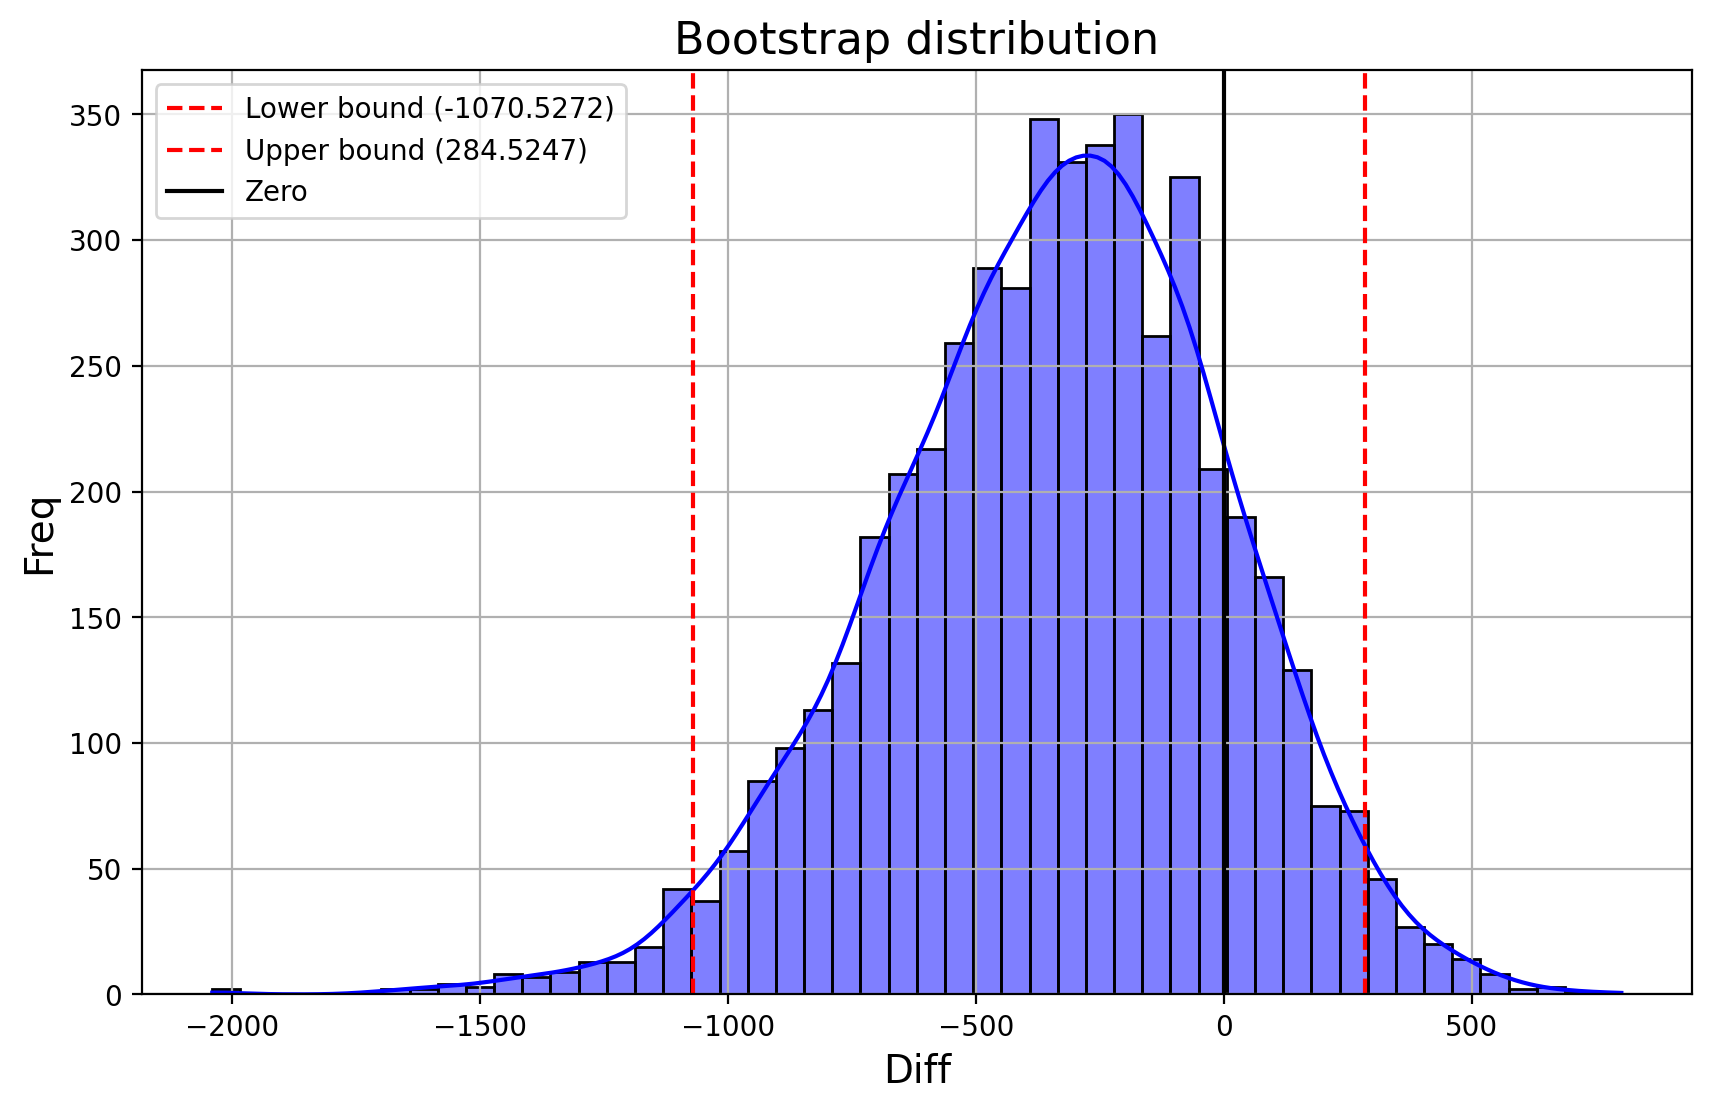

In [676]:
plt.figure(figsize=(10, 6))
sns.histplot(bootstrap_means, bins=50, kde=True, color='blue', edgecolor='black')

plt.axvline(lower_bound, color='red', linestyle='--', label=f'Lower bound ({lower_bound:.4f})')
plt.axvline(upper_bound, color='red', linestyle='--', label=f'Upper bound ({upper_bound:.4f})')

plt.axvline(0, color='black', linestyle='-', label='Zero')

plt.title('Bootstrap distribution', fontsize=16)
plt.xlabel('Diff', fontsize=14)
plt.ylabel('Freq', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

In [689]:
def generate_random_floats(n=70, start=30, end=91):
    values = [round(x, 2) for x in range(int(comparison_test['test_city_metric'].min()), int(comparison_test['test_city_metric'].max()))]
    return np.array(random.choices(values, k=n))


generate_random_floats(n=56*2, start=30, end=91)

array([6424, 4340, 6095, 4346, 3733, 5748, 4771, 6173, 6270, 4583, 6053,
       3909, 6314, 6092, 6185, 4587, 4946, 3907, 6253, 4899, 6296, 4846,
       6018, 3579, 5047, 3956, 5850, 4871, 4026, 4656, 3943, 4410, 6308,
       6183, 3831, 3896, 5609, 3594, 5855, 6150, 3642, 5484, 6024, 6412,
       5390, 6516, 6040, 3826, 3808, 6221, 3659, 6290, 4874, 4798, 5454,
       4658, 3724, 4816, 5711, 5211, 4559, 5580, 5113, 4670, 4321, 5930,
       3688, 5395, 5765, 3657, 4863, 5654, 6100, 4076, 4051, 3617, 4907,
       4674, 4612, 4533, 5586, 4602, 3753, 4037, 3884, 4239, 4252, 4164,
       6220, 4228, 4401, 3929, 6420, 5420, 6053, 6531, 4787, 3628, 6308,
       4065, 3824, 4867, 5224, 4640, 6458, 6208, 5385, 5954, 4778, 5176,
       3577, 4744])

In [690]:
# T-TEST
combined = generate_random_floats(n=70, start=30, end=91)

mean = np.mean(combined)
std = comparison_test.std().mean()
sample_size = [60, 70, 90]

expab.get_mde(mean, std, sample_size, alpha=0.10, beta=0.2)

,sample_size,mde_abs,mde_%,alpha,beta
0,60,591.9814,12.1427,0.1000,0.2000
1,70,548.0682,11.2420,0.1000,0.2000
2,90,483.3508,9.9145,0.1000,0.2000


# Summarising